Will try K from 1 to 10 , do you want to change it?
y/n: y
Please tell me the value of new K.
new_K: 5
How many times you will run kmeans when k is not change?
Repeat: 10
rank =  0
rank =  0
rank =  0
rank =  0
rank =  0
The dataset may have  5  clusters


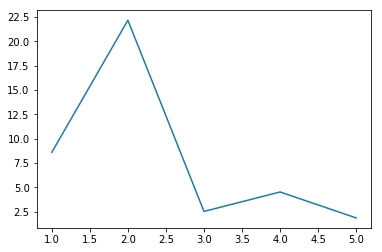

In [38]:
#import all library we need to use
#from numpy import *
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt #comment this sentence

comm = MPI.COMM_WORLD
size = comm.Get_size() #get the number of how many rank we have
rank = comm.Get_rank() #get the rank name
node_name = MPI.Get_processor_name() # get the name of the node

#process data
#determine the value of K in Kmeans
def set_K():
    max_K= 10 # this means the largest K we will test in our program, default 10
    print("Will try K from 1 to",max_K,", do you want to change it?");
    det_ew_K = input("y/n: ");
    if(det_ew_K == "y"):
        print("Please tell me the value of new K.");
        max_K = int(input("new_K: "));
    return max_K

#calculate Euclid distance between two points
#don't forget normalize your data before you use E distance
def E_distance(point_a, point_b):
    return sum(pow(point_a - point_b,2))#np.sqrt(sum(pow(point_a - point_b,2)))

#set the center of each cluster
def set_center(data,num_k):
    # Madhu Yedla et al's method
    #first check whether the dataset have negative value
    #data should be array 
    data_pro = np.array(data)
    for j in range(np.size(data_pro,1)):
        if min(data_pro[:,j]) < 0:       #if dataset have negative value, then move the dataset
            data_pro[:,j] = data_pro[:,j] - np.resize(min(data_pro[:,j]), np.size(data_pro,0))
    #then calculate the distance from each point to the center of coordinator
    distance = np.zeros(np.size(data_pro,0))
    for i in range(np.size(data_pro,0)):
        distance[i] = E_distance(data_pro[i,:], np.zeros(np.size(data_pro,1)))
        #distance[1,i] = i  #save the point index of each distance
    #order the distance
    index = np.argsort(distance) #sort the number and get the original index
    #divide the dataset to K different classes
    num_per_class = int(np.size(data_pro,0)/num_k)
    #then find the point which have the meidum distance in this class as the center  point of this classes
    result = []
    for k in range(0,np.size(data_pro,0),num_per_class+1):
        result.append(index[int(k + num_per_class/2)]) #save the point index
        
    return result

def find_center(data,k): 
    if np.size(data) != 0:
        center = np.zeros(np.size(data,1)) #the center of dataset
        for j in range(np.size(data,1)): #how many vertical lines we have
            sum_h = 0  
            for i in range(np.size(data,0)): #how many horizontal lines we have
                sum_h = sum_h + data[i,j]
            center[j] = sum_h / np.size(data,0)
        return center
    else:
        return np.zeros(k)
        
def stop_or_not(center_new, center_old):
    error = sum(np.array(center_new) - np.array(center_old))/np.size(center_new)
    if error < 0.1:
        return true
    else:
        return false
    
##################this two functions is used to calculate SSE#####   
def cal_SSE_part(data,k):
    SSE = 0
    center = find_center(np.array(data),k)
    for i in range(np.size(data,1)): #how many points in this cluster
        for j in range(i+1,np.size(data,1)): ################this part need mpi
            SSE = SSE + E_distance(data[i][:],center)
    return SSE/(2*np.size(data,1))
    #return SSE
def cal_SSE(data,k):
    SSE = 0
    #print("data have ",np.size(data,0), "clusters")
    for i in range(np.size(data,0)):
        part = data[i]
        SSE = SSE + cal_SSE_part(part,k)
    return SSE
##################this two functions is used to calculate SSE#####   

def kmeans(data,k):
    #k = set_K()
    r = 0 # how many round we will run for kmeans
    initial_point_index = set_center(data,k)
    initial_point = []
    group = []
    group_original = []
    past_center = []
    center = []
    for i in range(k):
        initial_point.append(data[initial_point_index[i]]) 
        group.append([]) #initialize group
        group_original.append([]) #initialize group
        center.append(np.zeros(np.size(data,1))) #initialize the center array
        past_center.append(np.ones(np.size(data,1))) #initialize the past_center array
    #the core of kmeans
    while(r < 15): #(stop_or_not(center,past_center)): 
        group = group_original #refresh group each time
        for i in range(np.size(data,0)):
            min_d = np.inf
            g = 0
            for j in range(k):
                if min_d > E_distance(data[i,:],np.array(initial_point[j][:])):
                    min_d = E_distance(data[i,:],np.array(initial_point[j][:]))
                    g = j
            group[g].append(data[i,:]) #generate new group
        past_center = center
        for i in range(k):
            initial_point[i] = find_center(np.array(group[i])) #refresh center point
        r = r + 1
    return group
#########################
#generate dataset to test
mean = [0,5]
cov = [[1,0],[0,1]]
mean1 = [10,8]
cov1 = [[1,0],[0,1]]
mean2 = [5,0]
cov2 = [[1,0],[0,1]]
mean3 = [5,-5]
cov3 = [[1,0],[0,1]]
k = 4
data = np.random.multivariate_normal(mean, cov, 5000)
data1 = np.random.multivariate_normal(mean1, cov1, 5000)
data2 = np.random.multivariate_normal(mean2, cov2, 5000)
data3 = np.random.multivariate_normal(mean3, cov3, 5000)
data_all = np.concatenate((data,data1,data2,data3),axis = 0) #the final dataset to test
#########################

# warning: didn't consider the condition when the number of processors we use smaller than the number in dataset
#use mpi parallel run kmeans
# repeat: means how many times you will run kmeans when k is not change
# size: how many task (or node) we have right now
# rank: which node we are using right now
#read size and node number(rank)

data = data_all # we already konw data right now
k_use = set_K()
#k_use = 5 #how many class you have
print("How many times you will run kmeans when k is not change?");
repeat = int(input("Repeat: "));
def kmeans_MPI(k, data, repeat):
    r = 0
    initial_point_index = set_center(data,k)
    initial_point = []
    group = []
    group_original = []
    past_center = []
    center = []
    print("rank = ",rank)
    for i in range(k):
        initial_point.append(data[initial_point_index[i]]) 
        group.append([]) #initialize group
        group_original.append([]) #initialize group
        center.append(np.zeros(np.size(data,1))) #initialize the center array
        past_center.append(np.ones(np.size(data,1))) #initialize the past_center array
    if rank == 0:
        #the core of kmeans
        while r < repeat:
            group = [[] for i in range(k)]
            #group = group_original #refresh group each time
            #print(group)
            for i in range(int(np.size(data,0)/(size-rank))): #take database apart
                min_d = np.inf
                g = 0
                for j in range(k):
                    if min_d > E_distance(data[i,:],np.array(initial_point[j][:])):
                        min_d = E_distance(data[i,:],np.array(initial_point[j][:]))
                        g = j
                group[g].append(data[i,:]) #generate new group
            new_data_start = int(np.size(data,0)/(size-rank)) #this size will used in other thread
            if(size > 1):
                for i in range(1,size): # send data to other processor
                    comm.send(np.size(data),dest = i)
                    #comm.send(data,dest = i)
                    if i != 1:
                        new_data_start = new_data_start + int((np.size(data) - new_data_start)/(size-i))
                    comm.send(new_data_start,dest = i)

                #comm.send(group) #??????

                for i in range(1,size): # receive data from other processor
                    group_sub = comm.recv(source = i)
                    for j in range(k):
                        group[j] = np.vstack(group[j],group_sub[j]) #have some problem?????????????????????

            #find center
            #past_center = center
            for i in range(k):
                initial_point[i] = find_center(np.array(group[i]),np.size(data,1)) #refresh center point

            r = r + 1
        #plot the figure
            #print(initial_point)
        return group
        #for i in range(np.size(group,0)):
        #    a = np.array(group[i])
           ##plt.figure(i)
        #    plt.plot(a[:,0],a[:,1],'.')
        ##plot center
        #for i in range(k):
            #plt.plot(initial_point[i][0],initial_point[i][1],'+')
    if rank > 0:
        data_size = comm.recv(source = 0)
        #data = comm.recv(source = 0)
        new_data_start = comm.recv(source = 0)
        print("new_data_start = ",new_data_start)
        for i in range(new_data_start,new_data_start+int((np.size(data) - new_data_start)/(size-rank))): #take database apart
                min_d = np.inf
                g = 0
                for j in range(k):
                    if min_d > E_distance(data[i,:],np.array(initial_point[j][:])):
                        min_d = E_distance(data[i,:],np.array(initial_point[j][:]))
                        g = j
                group[g].append(data[i,:]) #generate new group
            #new_data_size = new_data_size - new_data_size/(size-rank) #this size will used in other thread

        comm.send(group, dest = 0)
        
#kmeans_MPI(k, data, repeat)
final_k = 0
SSE = np.zeros(k_use)
final_SSE = np.inf
for k in range(1,k_use+1):
    group = []
    group = kmeans_MPI(k, data, repeat)
    a = cal_SSE(group,k)
    if final_SSE > a:
        final_SSE = a
        final_k = k
    SSE[k-1] = a
    gap = np.log(SSE)
    for i in range(np.size(group,0)):
        a = np.array(group[i])
        plt.figure(k)
        plt.plot(a[:,0],a[:,1],'.')
plt.figure(k+1)
plt.plot(np.array(range(1,k_use+1)),SSE,'-')
print("The dataset may have ",final_k," clusters")

In [37]:
#plt.plot(np.array(range(1,k_use+1)),SSE,'-')